Combined Data shape: (117932, 18)
Normal Features Before Transformation shape: (58930, 17)
Transformed Normal Data shape: (58930, 18)
Data Transformed After Transformation shape: (117932, 18)
Data Transformed After Dropping NaN Columns shape: (117932, 12)
Features Transformed shape: (117932, 11)
Features Cleaned shape: (117932, 12)
Euclidean Distance: Mean = 40837.089152077424, Std Dev = 23354.000077635294


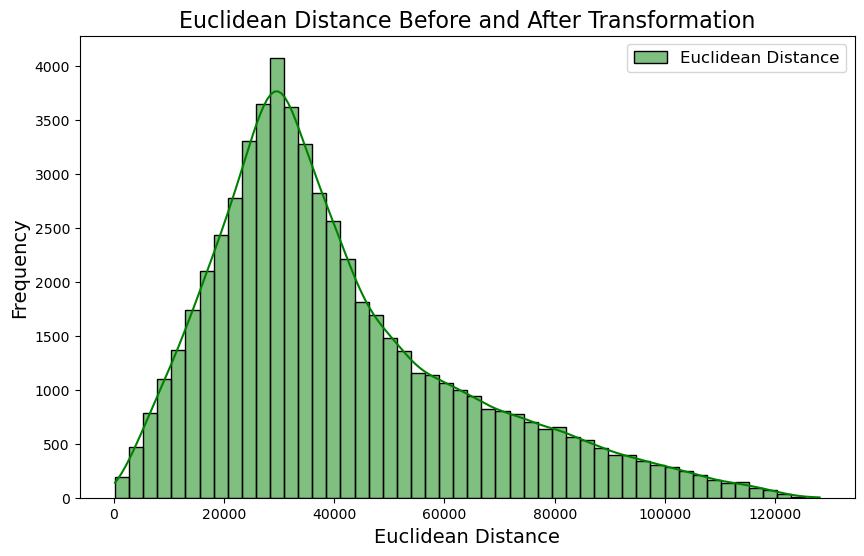

X_train shape: (82552, 11)
X_test shape: (35380, 11)
Class distribution in y_train:
label
1    41301
0    41251
Name: count, dtype: int64
X_train_resampled shape: (82552, 11)
Class distribution after SMOTE:
label
1    41301
0    41251
Name: count, dtype: int64


C:\Users\nagas\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 41301, number of negative: 41251
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2555
[LightGBM] [Info] Number of data points in the train set: 82552, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500303 -> initscore=0.001211
[LightGBM] [Info] Start training from score 0.001211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

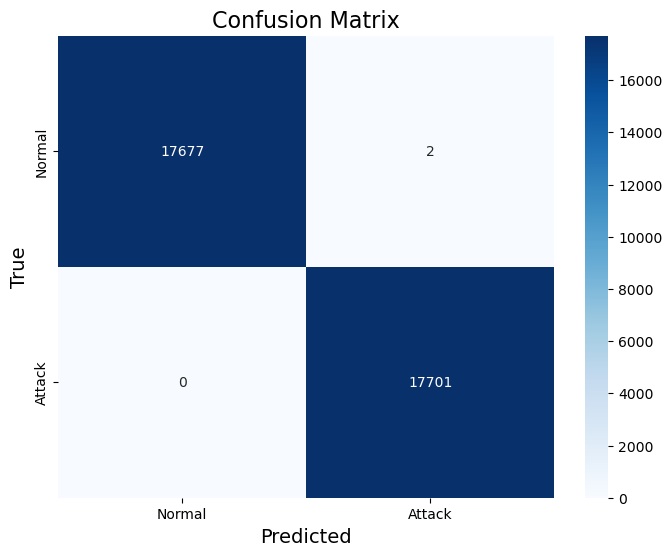

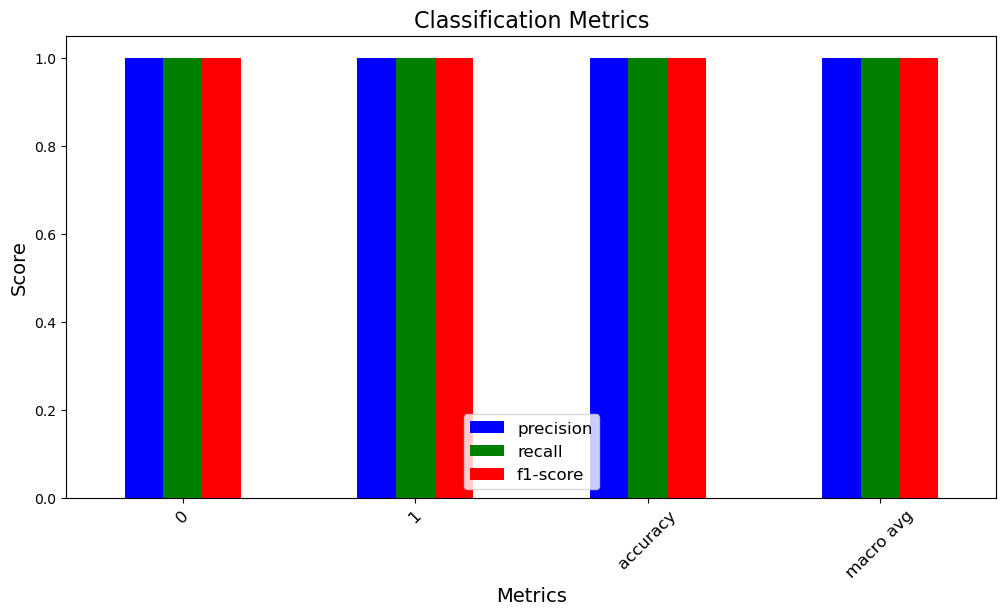

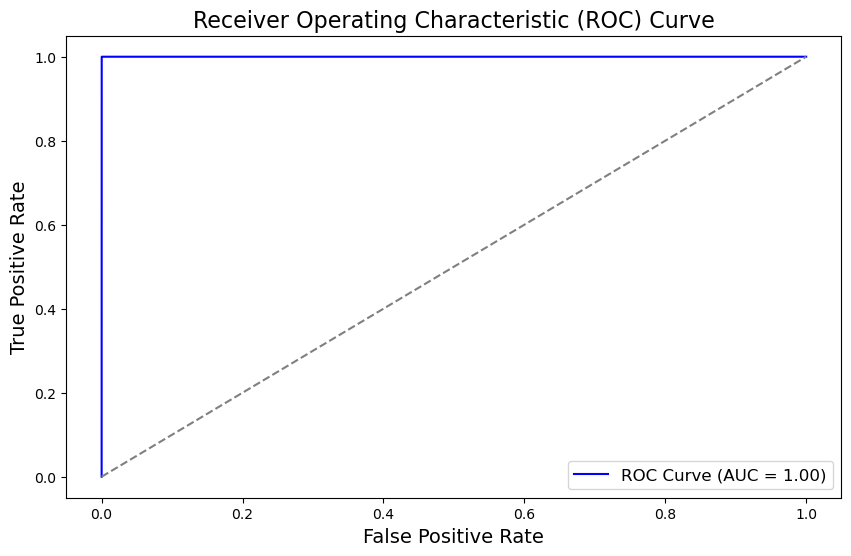

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from scipy.spatial.distance import cosine, euclidean

# Debugging function to check shape alignment
def debug_shape(df, name="DataFrame"):
    print(f"{name} shape: {df.shape}")

# Function to safely load CSV files
def safe_load_csv(filepath):
    try:
        return pd.read_csv(filepath, delimiter=';', encoding='utf-8')
    except pd.errors.ParserError:
        print(f"Error loading {filepath}. Attempting to skip problematic rows...")
        return pd.read_csv(filepath, on_bad_lines='skip', delimiter=';', encoding='utf-8')

# 1. Load datasets
normal = safe_load_csv(r"C:\Users\nagas\OneDrive\Desktop\eocs\ics-dataset-for-smart-grids\but-iec104-i\normal-traffic.csv")
switching_attack = safe_load_csv(r"C:\Users\nagas\OneDrive\Desktop\eocs\ics-dataset-for-smart-grids\but-iec104-i\switching-attack.csv")

# 2. Assign labels
normal['label'] = 0
switching_attack['label'] = 1

# Combine all data
data = pd.concat([normal, switching_attack], ignore_index=True)
debug_shape(data, "Combined Data")

# Check for mixed or improperly parsed columns and clean
def clean_data_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

data = clean_data_columns(data)

# 3. Apply a stronger transformation to normal data
def transform_normal_data(data, noise_level=0.5):
    noise = np.random.normal(0, noise_level, data.shape)
    scaled_data = data * np.random.uniform(0.5, 1.5, data.shape)
    transformed_data = scaled_data + noise
    return transformed_data

normal_features = data[data['label'] == 0].drop(columns=['label'])
debug_shape(normal_features, "Normal Features Before Transformation")

# Apply transformation to normal data
transformed_normal_features = transform_normal_data(normal_features.to_numpy(), noise_level=0.5)
transformed_normal = pd.DataFrame(transformed_normal_features, columns=normal_features.columns)  # Ensure column names match
transformed_normal['label'] = 0  # Add label back to match original structure
debug_shape(transformed_normal, "Transformed Normal Data")

# Combine transformed normal data back with attack class
attack_data = data[data['label'] == 1]
data_transformed = pd.concat([transformed_normal, attack_data], ignore_index=True)
debug_shape(data_transformed, "Data Transformed After Transformation")

# Ensure consistency in data cleaning
data_transformed = clean_data_columns(data_transformed)

# 4. Handle missing values
non_nan_columns = data_transformed.columns[data_transformed.notna().any()].tolist()
data_transformed = data_transformed[non_nan_columns]
debug_shape(data_transformed, "Data Transformed After Dropping NaN Columns")

# Separate features and labels
features_transformed = data_transformed.drop(columns=['label'])
label_transformed = data_transformed['label']
debug_shape(features_transformed, "Features Transformed")

# Impute missing values
imputer = SimpleImputer(strategy='median')
features_cleaned = imputer.fit_transform(features_transformed)

# Ensure column alignment
features_cleaned_df = pd.DataFrame(features_cleaned, columns=features_transformed.columns)
features_cleaned_df['label'] = label_transformed.reset_index(drop=True)
debug_shape(features_cleaned_df, "Features Cleaned")

# 5. Feature selection and preprocessing
scaler = StandardScaler()

numerical_features = [col for col in features_cleaned_df.columns if col != 'label']
features_cleaned_df[numerical_features] = scaler.fit_transform(features_cleaned_df[numerical_features])
features_cleaned_df['label'] = features_cleaned_df['label'].astype(int)

# Ensure no NaN or inf values in normal_features and transformed_normal_features
normal_features_clean = np.nan_to_num(normal_features.to_numpy(), nan=0.0, posinf=0.0, neginf=0.0)
transformed_normal_features_clean = np.nan_to_num(transformed_normal_features, nan=0.0, posinf=0.0, neginf=0.0)

euclidean_distances = [euclidean(original, transformed) 
                       for original, transformed in zip(normal_features_clean, transformed_normal_features_clean)]

euclidean_mean = np.mean(euclidean_distances)
euclidean_std = np.std(euclidean_distances)

print(f"Euclidean Distance: Mean = {euclidean_mean}, Std Dev = {euclidean_std}")

# Plot Euclidean Distance
plt.figure(figsize=(10, 6))
sns.histplot(euclidean_distances, kde=True, bins=50, color='green', label='Euclidean Distance')
plt.title('Euclidean Distance Before and After Transformation', fontsize=16)
plt.xlabel('Euclidean Distance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.show()

# 6. Split data
X = features_cleaned_df.drop(columns=['label'])
y = features_cleaned_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
debug_shape(X_train, "X_train")
debug_shape(X_test, "X_test")

# Check class distribution before resampling
print("Class distribution in y_train:")
print(y_train.value_counts())

# 7. Handle imbalance using SMOTE
# Ensure we are oversampling the minority class to at least match the majority class count
majority_class_count = y_train.value_counts().max()
smote = SMOTE(sampling_strategy={1: majority_class_count}, random_state=42)  # Oversample minority to match majority

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
debug_shape(X_train_resampled, "X_train_resampled")

# Check class distribution after resampling
print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())

# 8. Train classifier - Using LightGBM instead
clf = LGBMClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Calculate and print training accuracy
y_train_pred = clf.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# 9. Evaluate the model
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
test_accuracy = accuracy_score(y_test, y_pred)

# Generate ROC Curve
y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"Testing Accuracy: {test_accuracy:.2f}")

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

# Metrics Plot
metrics_df = pd.DataFrame(report).transpose().iloc[:-1, :3]
metrics_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'green', 'red'])
plt.title('Classification Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(fontsize=12)
plt.show()

# ROC Curve Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(fontsize=12)
plt.show()